# **Introducción**

Telecom X es una empresa de telecomunicaciones y has sido contratado como analista de datos para trabajar en un proyecto específico de Churn de clientes. La empresa está enfrentando un alto índice de evasión de clientes y aún no han identificado el problema de esta evasión. Para ello, te han proporcionado algunos datos en los que tendrás que buscar, tratar y realizar un análisis exploratorio para, una vez limpiados estos datos, poder proporcionárselos al equipo de ciencia de datos. De esta manera, podrán realizar un análisis predictivo y determinar de dónde proviene esta evasión de clientes.

## **1. Importación de bibliotecas**
Antes de comenzar, importamos las bibliotecas esenciales para el procesamiento de datos, visualización y aprendizaje automático.

In [1]:
# Importaciones necesarias
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import requests
import json
import plotly.graph_objects as go
from plotly.subplots import make_subplots


## 2. Carga y exploración inicial del dataset
Cargamos el dataset y realizamos una exploración inicial para entender su estructura, variables y posibles valores faltantes.

In [2]:
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"

try:
    response = requests.get(url)
    response.raise_for_status() # Raise an exception for bad status codes

    # Parse the JSON content
    data = json.loads(response.text)

    print("Data extracted successfully!")
    # You can now work with the 'data' variable which contains the parsed JSON
    # print(data) # Uncomment to see the extracted data

except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}")
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")


Data extracted successfully!


In [3]:
try:
    df = pd.DataFrame(data)
    print("DataFrame created successfully!")

except Exception as e:
    print(f"Error creating DataFrame: {e}")

DataFrame created successfully!


In [4]:
df.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


In [7]:
# Normalizar
customer_df = pd.json_normalize(df['customer'])
phone_df = pd.json_normalize(df['phone'])
internet_df = pd.json_normalize(df['internet'])
account_df = pd.json_normalize(df['account'])

# Concatenar
df = pd.concat([df.drop(['customer', 'phone', 'internet', 'account'], axis=1), customer_df, phone_df, internet_df,account_df], axis=1)

df.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


## 3. Limpieza y preprocesamiento de datos
Realizamos limpieza de datos, manejo de valores nulos y transformaciones necesarias para preparar el dataset para el modelado.

In [8]:
# Check for duplicates and missing values
print('Shape of dataframe:', df.shape)
print('Shape of dataframe with duplicates dropped:', df.drop_duplicates().shape)
#print('Total count of missing values:', df.isna().sum().sum())
#print('Missing values per column:')
#df.isna().sum()

Shape of dataframe: (7267, 21)
Shape of dataframe with duplicates dropped: (7267, 21)


In [40]:
#df.info()

In [41]:
#Obtenemos valores unicos de las filas Objeto ... para observar Variable Unicas
'''
df_objetos = df.select_dtypes(include=['object'])
for col in df_objetos.columns:
  print(f"Valores unicos en la columna {col}: {df_objetos[col].nunique()}")
  if df_objetos[col].nunique() < 10:
    print(df_objetos[col].unique())
    print('-'*50)
'''

'\ndf_objetos = df.select_dtypes(include=[\'object\'])\nfor col in df_objetos.columns:\n  print(f"Valores unicos en la columna {col}: {df_objetos[col].nunique()}")\n  if df_objetos[col].nunique() < 10:\n    print(df_objetos[col].unique())\n    print(\'-\'*50)\n'

In [32]:
#Eliminamos de 'Churn' el espacio 'vacio'
df.drop(df[df['Churn'] == ''].index, inplace=True)
df.reset_index(inplace=True, drop=True)

In [34]:
#Cambiar columna Charges.Total a float
df['Charges.Total'] = df['Charges.Total'].apply(pd.to_numeric, errors='coerce')

In [37]:
df.dropna(inplace=True, axis=0)
df.reset_index(inplace=True, drop=True)
# Rellena los NaN de una columna específica con la media
# df['A'] = df['A'].fillna(df['A'].mean())

In [42]:
# Check for missing values in dataframe
#print('Total count of missing values:', df.isna().sum().sum())
#print('Missing values per column:')
#df.isna().sum()

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   Churn             7032 non-null   object 
 2   gender            7032 non-null   object 
 3   SeniorCitizen     7032 non-null   int64  
 4   Partner           7032 non-null   object 
 5   Dependents        7032 non-null   object 
 6   tenure            7032 non-null   int64  
 7   PhoneService      7032 non-null   object 
 8   MultipleLines     7032 non-null   object 
 9   InternetService   7032 non-null   object 
 10  OnlineSecurity    7032 non-null   object 
 11  OnlineBackup      7032 non-null   object 
 12  DeviceProtection  7032 non-null   object 
 13  TechSupport       7032 non-null   object 
 14  StreamingTV       7032 non-null   object 
 15  StreamingMovies   7032 non-null   object 
 16  Contract          7032 non-null   object 


### Identificar Variable Cartegoricas y Numericas
Este fragmento de código realiza un análisis exploratorio de datos (EDA) enfocado en identificar patrones relacionados con el Churn (abandono de clientes) en un dataset. Se divide en dos partes:

Selección de variables clave (categóricas y numéricas).

In [44]:
#Hacemos una copia, para cambiar variables categoricas a numericas...
df_clean = df.copy()
# Verifica si 'Churn' es categórica 'Yes'/'No' o numérica 0/1 antes de mapear. Es la variable objetivo.
df_clean['Churn'] = df_clean['Churn'].map({'Yes': 1, 'No': 0})
# Verifica si 'SeniorCitizen' es numérica 0/1 o categórica 'Yes'/'No'
df_clean['SeniorCitizen'] = df_clean['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

# Eliminar columnas no necesarias - asegurate de que customerID exista si lo intentas eliminar
cols_to_drop = ['customerID']
df_clean = df_clean.drop(columns=cols_to_drop, errors='ignore')

In [45]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Churn             7032 non-null   int64  
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   object 
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


### Examine the class balance of your target variable.

In [46]:
# Get class balance of 'Churn' col
df_clean['Churn'].value_counts(normalize=True)

,proportion
Churn,
0,0.734215
1,0.265785


In [47]:
# Variables clave
# Churn es la Variable Objetive
cat_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
           'OnlineSecurity', 'TechSupport',
           'PaperlessBilling', 'PaymentMethod']


num_cols = ['tenure', 'Charges.Monthly', 'Charges.Total']

## 4. Análisis de datos
### Coeficiente V de Cramér
Esta función calcula el coeficiente V de Cramér, una medida de asociación entre dos variables categóricas. A diferencia de la correlación (que es para variables numéricas), el V de Cramér evalúa la fuerza y dirección de la relación entre dos variables categóricas, devolviendo un valor entre 0 (ninguna asociación) y 1 (asociación perfecta). Interpretación del resultado 0: No hay asociación entre las variables.

0.1 - 0.3: Asociación débil.

0.3 - 0.5: Asociación moderada.

`>` 0.5: Asociación fuerte.

In [48]:
def cramers_v(x, y):
    """Calcula el coeficiente V de Cramer para variables categóricas"""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

### Distributions
Esta función visualiza las distribuciones de variables categóricas en un DataFrame, mostrando cómo se relacionan con una variable objetivo (por defecto 'Churn'). Es útil para analizar el comportamiento de distintas categorías y su asociación con el abandono de clientes

In [49]:
def plot_distributions(df, columns, hue='Churn', max_cols=3):
    """Visualiza distribuciones de variables categóricas"""
    n_plots = len(columns)
    n_rows = (n_plots + max_cols - 1) // max_cols

    plt.figure(figsize=(18, 5*n_rows))
    for i, col in enumerate(columns, 1):
        plt.subplot(n_rows, max_cols, i)
        sns.countplot(data=df_clean, x=col, hue=hue)
        plt.title(f'{col} vs Churn')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Correlaciones entre Variables Numéricas y Categoricas.:
Esta función visualiza dos tipos de correlaciones en un DataFrame:

*   Correlación entre variables numéricas (matriz de Pearson).
*   Correlación entre variables categóricas (matriz de V de Cramér).

Es útil para identificar relaciones entre variables que pueden ser relevantes para análisis exploratorios o modelado predictivo.

In [50]:
def plot_correlations(df, num_cols, cat_cols):
    """Visualiza correlaciones numéricas y categóricas"""
    # Correlación numérica
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_clean[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f', center=0)
    plt.title('Correlación entre Variables Numéricas')
    plt.show()
    print()
    print()
    # Correlación categórica
    cramer_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)
    for col1 in cat_cols:
        for col2 in cat_cols:
            cramer_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

    plt.figure(figsize=(14, 12))
    sns.heatmap(cramer_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=0, vmax=1)
    plt.title('Correlación Categórica (V de Cramer)')
    plt.show()

### Relación entre variables numéricas y la variable objetivo Churn.
Esta función visualiza la relación entre variables numéricas y la variable objetivo Churn (abandono de clientes) mediante gráficos de caja (boxplots). Su objetivo es comparar cómo se distribuyen las variables numéricas entre los clientes que abandonaron (Churn='Yes') y los que no (Churn='No').

In [51]:
def plot_numerical_vs_churn(df, num_cols):
    """Visualiza la relación entre variables numéricas y churn"""
    plt.figure(figsize=(16, 4))
    for i, col in enumerate(num_cols, 1):
        plt.subplot(1, len(num_cols), i)
        sns.boxplot(data=df_clean, x='Churn', y=col)
        plt.title(f'{col} vs Churn')
    plt.tight_layout()
    plt.show()

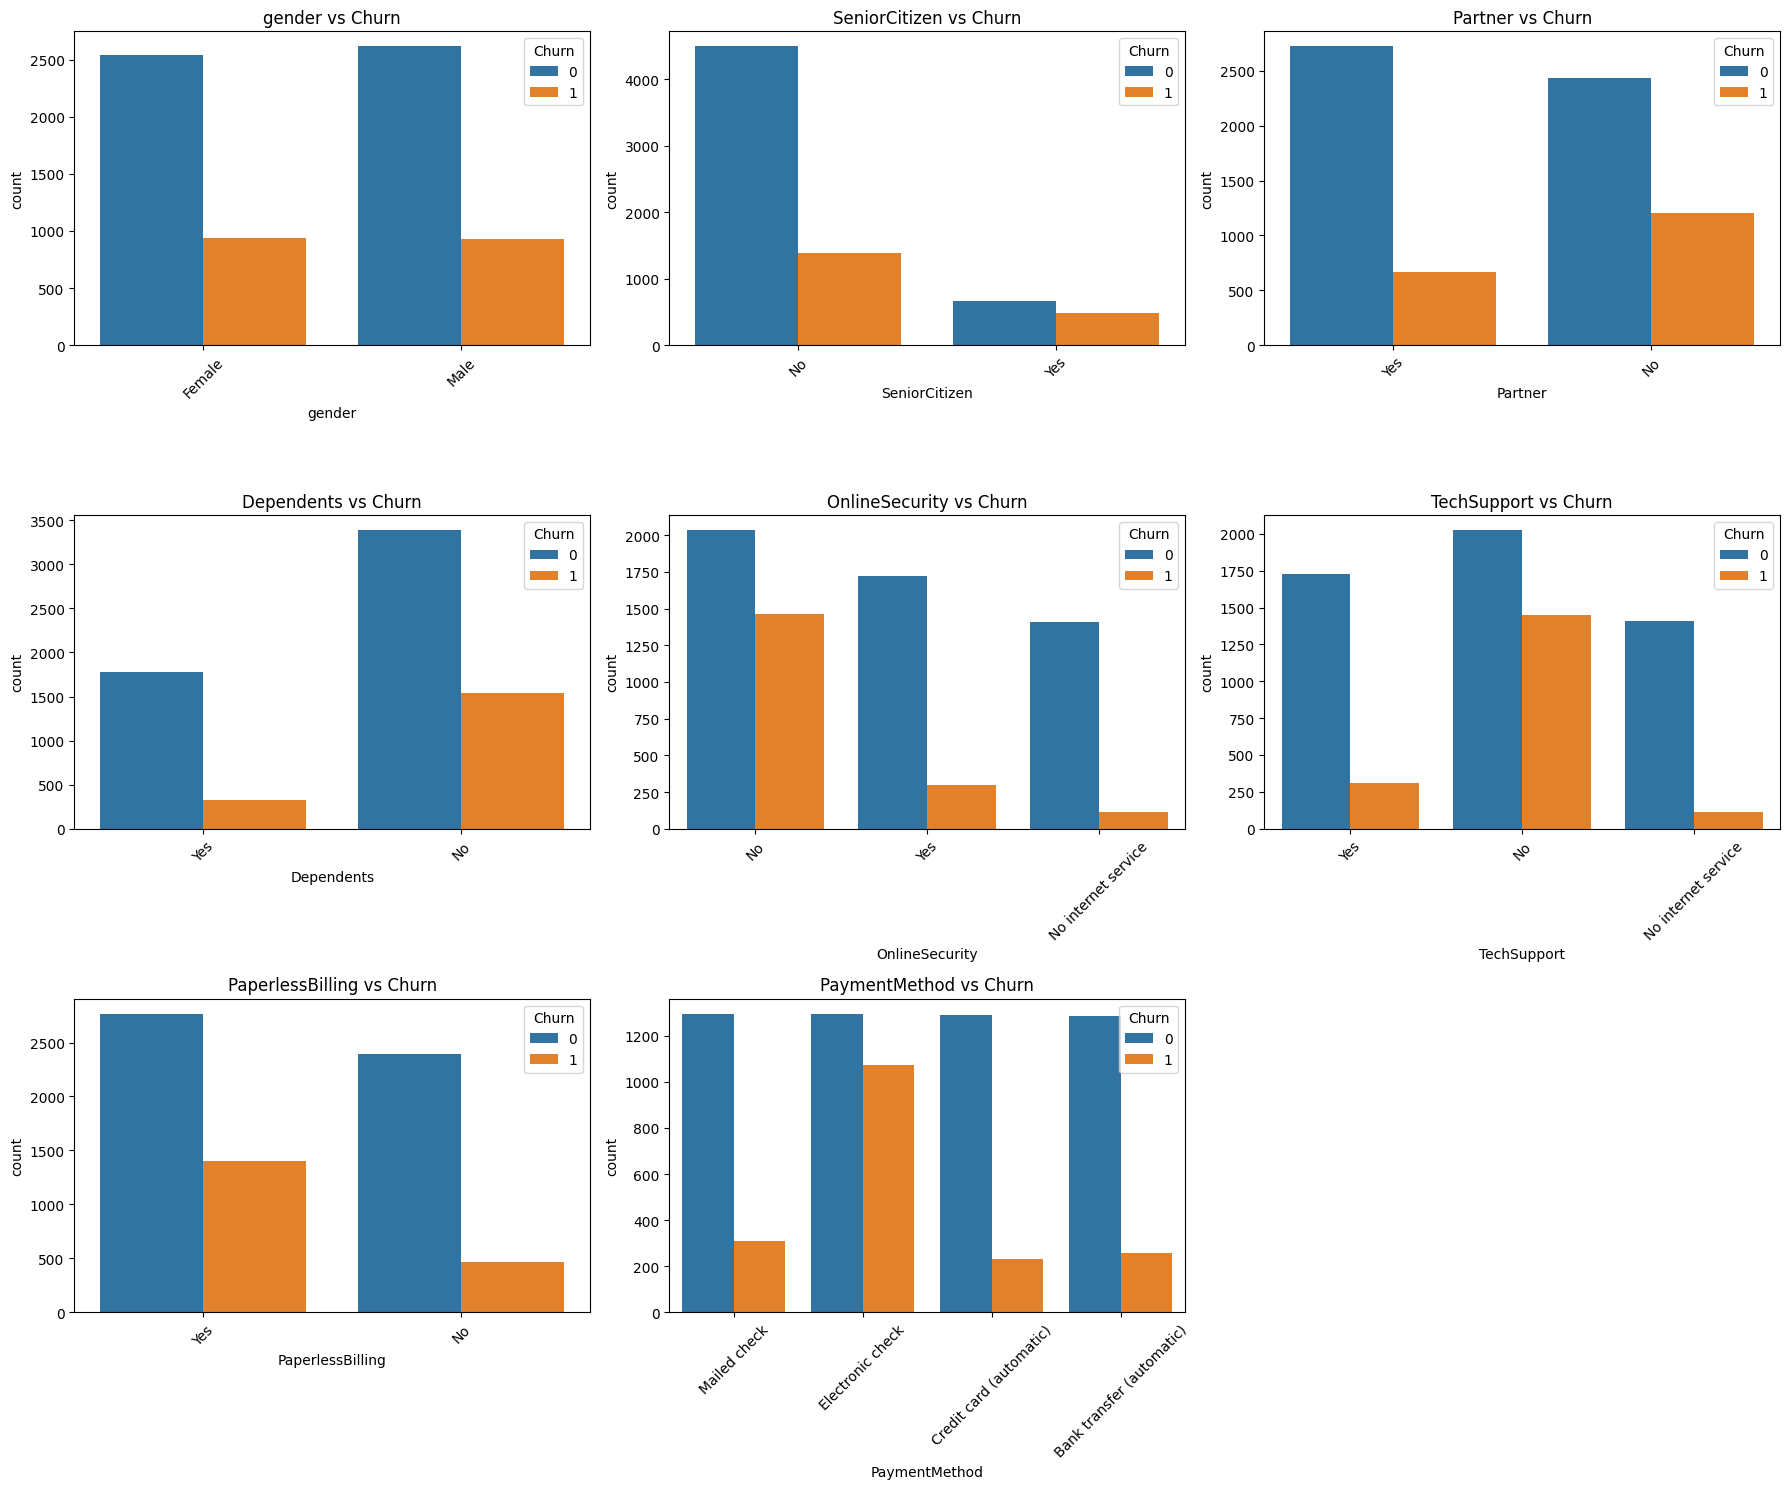

In [ ]:
# Visualizacione_1
plot_distributions(df_clean, cat_cols)

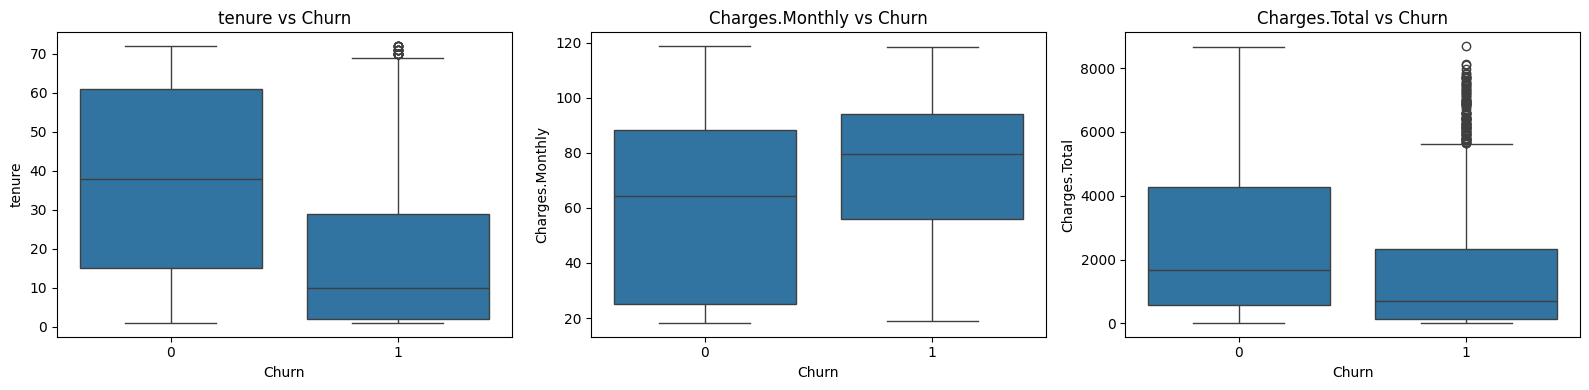

In [ ]:
#Visualizacion_2
plot_numerical_vs_churn(df_clean, num_cols)

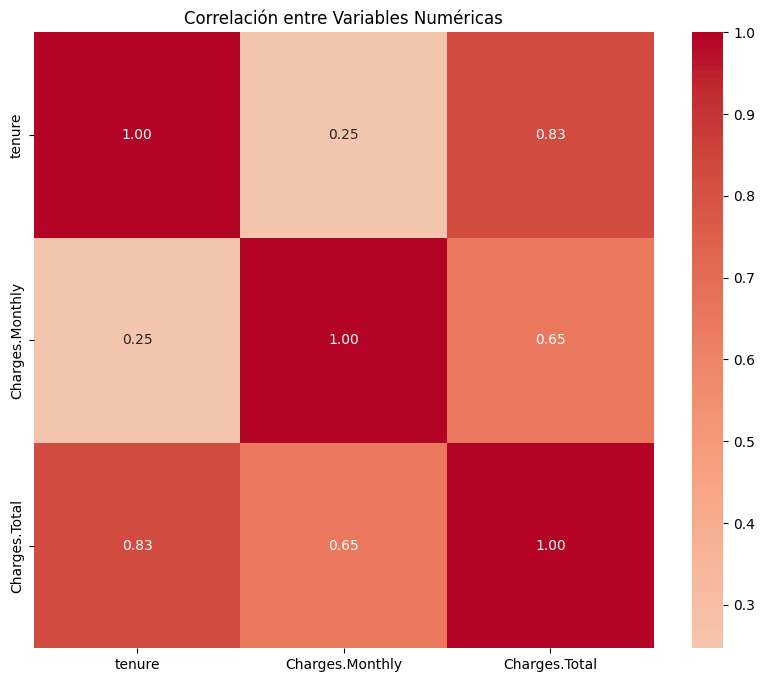

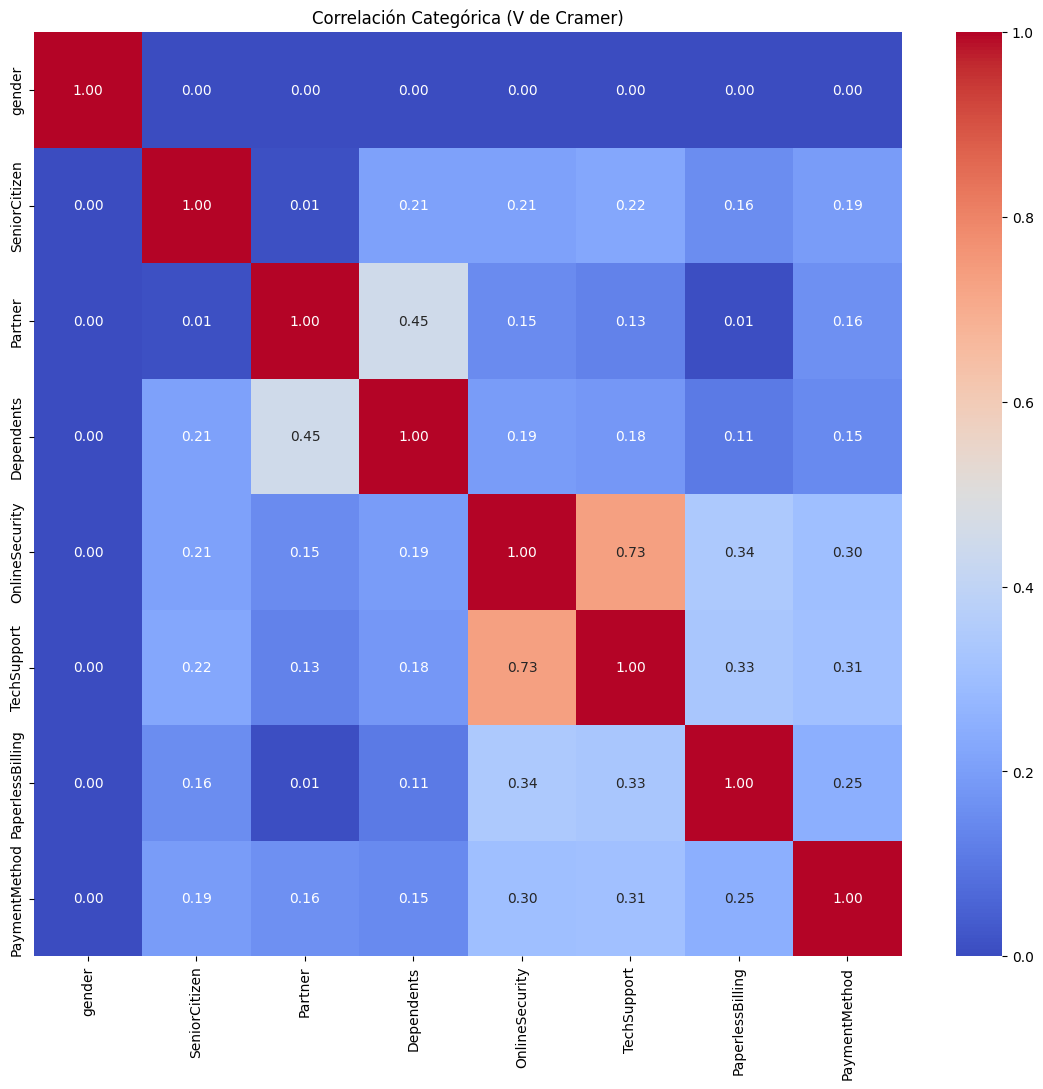

In [ ]:
#Visualización_3
plot_correlations(df_clean, num_cols, cat_cols[:8])

### Analisis por Segmentación:
La siguiente función realia Análisis x Segmentación:

In [60]:
def analyze_segments(df_clean, segment_cols, target='Churn', palette_name='husl'):
    """Analiza tasas de churn por segmentos con estilo minimalista

    Args:
        df (pd.DataFrame): DataFrame con los datos
        segment_cols (list): Lista de columnas para segmentar
        target (str): Columna objetivo (default 'Churn')
        palette_name (str): Nombre de la paleta de colores (default 'husl')
    """
    # Configuración de estilo minimalista
    sns.set(style="white")  # Elimina fondos y líneas innecesarias

    for col in segment_cols:
        # Crear figura sin márgenes superiores y derechos
        fig, ax = plt.subplots(figsize=(10, 5))

        # Calcular datos para el gráfico
        segment_data = df_clean.groupby(col)[target].mean().sort_values(ascending=False)

        # Crear paleta de colores
        custom_palette = sns.color_palette(palette_name, len(segment_data.index))

        # Crear gráfico de barras
        sns.barplot(x=segment_data.index,
                    y=segment_data.values,
                    palette=custom_palette,
                    hue=segment_data,
                    legend=False,
                    ax=ax)

        # Personalización minimalista
        ax.set_title(f'Tasa de Churn por {col}', fontsize=14, pad=15)
        ax.set_ylabel('Tasa de Churn', fontsize=12)
        ax.set_xlabel('')

        # Añadir valores en las barras
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.1%}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center',
                       xytext=(0, 5),
                       textcoords='offset points',
                       fontsize=10)

        # Eliminar bordes/márgenes superiores y derechos
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Ajustar layout para minimizar espacios en blanco
        plt.tight_layout()
        plt.show()

        # Mostrar tabla con conteos (formato mejorado)
        print(f"\nDistribución y churn por {col}:")
        display(pd.concat([
            df_clean[col].value_counts(normalize=True).rename('Distribución').mul(100).round(1).astype(str) + '%',
            df_clean.groupby(col)[target].mean().rename('Tasa Churn').mul(100).round(1).astype(str) + '%'
        ], axis=1).sort_values('Tasa Churn', ascending=False))
        print()
plt.show()

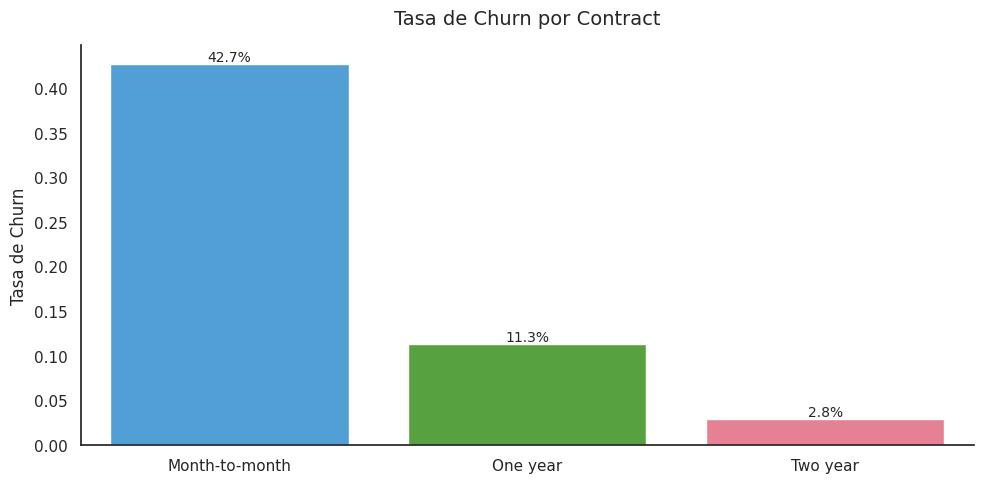


Distribución y churn por Contract:


,Distribución,Tasa Churn
Contract,,
Month-to-month,55.1%,42.7%
Two year,24.0%,2.8%
One year,20.9%,11.3%


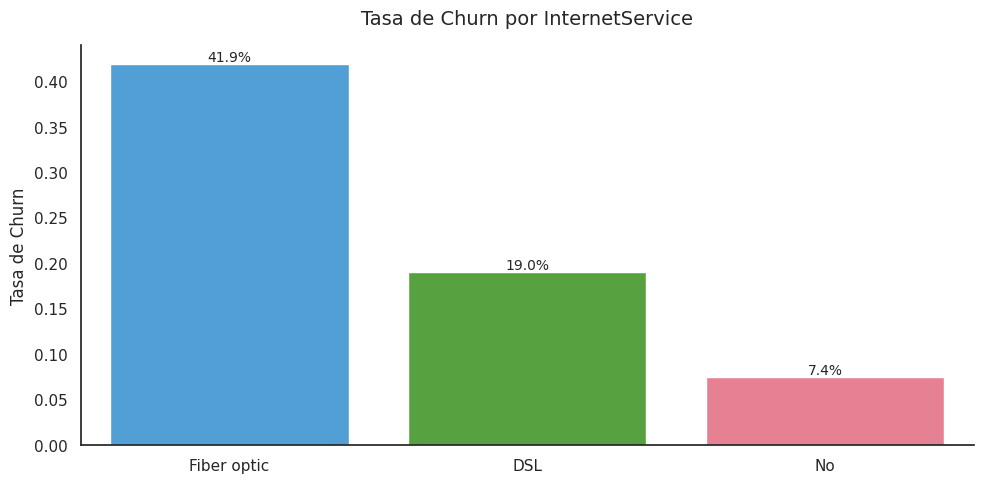


Distribución y churn por InternetService:


,Distribución,Tasa Churn
InternetService,,
No,21.6%,7.4%
Fiber optic,44.0%,41.9%
DSL,34.4%,19.0%


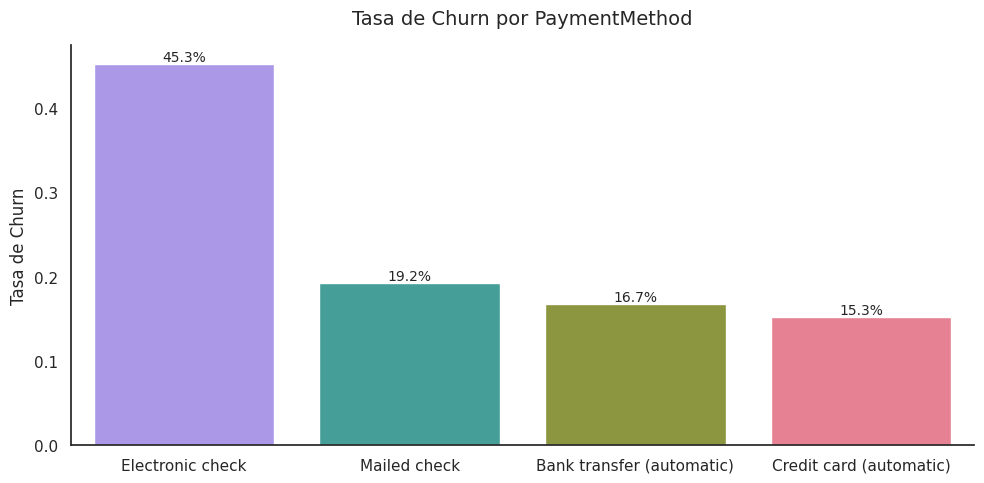


Distribución y churn por PaymentMethod:


,Distribución,Tasa Churn
PaymentMethod,,
Electronic check,33.6%,45.3%
Mailed check,22.8%,19.2%
Bank transfer (automatic),21.9%,16.7%
Credit card (automatic),21.6%,15.3%


In [61]:
analyze_segments(df_clean, ['Contract', 'InternetService', 'PaymentMethod'])

## Feature Engineering
Este código tiene como objetivo mejorar el conjunto de datos original mediante la creación de nuevas características (features) que pueden ser más informativas para un modelo predictivo de Churn. La función create_new_features() realiza tres transformaciones principales:

Número de servicios contratados (NumServices): Suma cuántos servicios adicionales (como OnlineSecurity, StreamingTV, etc.) tiene cada cliente (contabilizando los valores 'Yes'). Esto ayuda a cuantificar la "lealtad" o compromiso del cliente con la empresa.

Grupos de antigüedad (TenureGroup): Clasifica a los clientes en categorías según su tiempo de permanencia (tenure), como "0-1 año", "1-2 años", etc. Esto simplifica el análisis de patrones basados en la antigüedad.

Cliente premium (PremiumCustomer): Identifica clientes con servicios de Internet Fiber optic y cuyos cargos mensuales están por encima de la mediana. Esta variable binaria (1/0) puede capturar a un segmento de alto valor.

In [ ]:
df_clean.head()

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0,Female,No,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0,Male,No,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,1,Male,No,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,1,Male,Yes,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,1,Female,Yes,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


El DataFrame resultante (df) incluye las nuevas columnas (NumServices, TenureGroup, PremiumCustomer), manteniendo los datos originales intactos (gracias al .copy()). Estas features sintéticas pueden mejorar la capacidad del modelo para identificar patrones complejos, como que los clientes con muchos servicios o antigüedad media tengan menor probabilidad de abandonar.

In [63]:
## Feature Engineering
def create_new_features(df):
    """Crea nuevas características para el modelado"""
    df_fe = df_clean.copy()

    # Servicios adicionales contratados
    services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV', 'StreamingMovies']
    df_fe['NumServices'] = df_fe[services].apply(lambda x: sum(x == 'Yes'), axis=1)

    # Grupo de antigüedad
    df_fe['TenureGroup'] = pd.cut(df_fe['tenure'], bins=[0, 12, 24, 48, 72],
                                labels=['0-1 año', '1-2 años', '2-4 años', '4+ años'])

    # Cliente con servicios premium
    df_fe['PremiumCustomer'] = ((df_fe['InternetService'] == 'Fiber optic') &
                               (df_fe['Charges.Monthly'] > df_fe['Charges.Monthly'].median())).astype(int)

    return df_fe

df_fe = create_new_features(df_clean)


In [ ]:
df_fe.head()

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,NumServices,TenureGroup,PremiumCustomer
0,0,Female,No,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,3,0-1 año,0
1,0,Male,No,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,1,0-1 año,0
2,1,Male,No,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,1,0-1 año,1
3,1,Male,Yes,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,4,1-2 años,1
4,1,Female,Yes,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2,0-1 año,1


### 5. **Insights**
Este código genera un panel de visualizaciones diseñado para revelar insights clave sobre el comportamiento del Churn (abandono de clientes) en relación con diferentes variables del dataset. La función plot_final_insights() crea una figura con cuatro gráficos organizados en una cuadrícula de 2x2, cada uno enfocado en un aspecto distinto del análisis.
### Factores críticos que aumentan el Churn
- **Contratos mes a mes:** Los clientes con contratos mensuales (Month-to-month) tienen una tasa de Churn significativamente mayor (≈30%) en comparación con contratos anuales o bianuales (≈10%). Esto sugiere que la falta de compromiso a largo plazo es un riesgo alto.

- **Formas de pago:** Los clientes que usan "Electronic Check" como método de pago presentan mayor abandono que aquellos con pagos automáticos (tarjeta de crédito o transferencia bancaria).

- **Antigüedad baja:** El Churn es más alto en clientes con menos de 12 meses de antigüedad (tenure), indicando que la retención inicial es crítica.

In [71]:
import plotly.express as px

# Configurar el tamaño de todas las gráficas (opcional)
px.defaults.width = 1000  # 10 pulgadas a 100 dpi
px.defaults.height = 500   # 5 pulgadas a 100 dpi

# Gráfico interactivo de churn por grupo de antigüedad con paleta 'Viridis'
fig_tenure = px.bar(
    df_fe.groupby('TenureGroup', observed=True)['Churn'].mean().reset_index(),
    x='TenureGroup',
    y='Churn',
    title='Tasa de Churn por Grupo de Antigüedad',
    labels={'Churn': 'Tasa de Churn', 'TenureGroup': 'Grupo de Antigüedad (meses)'},
    color='Churn',
    color_continuous_scale='Viridis',
    width=1000,  # 10 pulgadas
    height=500   # 5 pulgadas
).update_layout(
    yaxis_tickformat=".0%",  # Formato porcentual
    coloraxis_colorbar=dict(title="Tasa Churn"),
    title_x=0.5  # Centrar título
)

# Gráfico interactivo de churn por tipo de contrato con paleta 'Plasma'
fig_contract = px.bar(
    df_fe.groupby('Contract')['Churn'].mean().reset_index(),
    x='Contract',
    y='Churn',
    title='Tasa de Churn por Tipo de Contrato',
    labels={'Churn': 'Tasa de Churn', 'Contract': 'Tipo de Contrato'},
    color='Churn',
    color_continuous_scale='Plasma',
    width=1000,  # 10 pulgadas
    height=500   # 5 pulgadas
).update_layout(
    yaxis_tickformat=".0%",  # Formato porcentual
    coloraxis_colorbar=dict(title="Tasa Churn"),
    title_x=0.5  # Centrar título
)

# Mostrar gráficos
fig_tenure.show()
fig_contract.show()

### Factores protectores contra el Churn
**Servicios adicionales:** Los clientes con más servicios contratados (OnlineSecurity, TechSupport, etc.) tienden a abandonar menos. Por ejemplo, quienes tienen 3+ servicios muestran una tasa de Churn del 15%, frente al 40% de quienes no tienen servicios adicionales. Existe una fuerte correlación (0.6-0.7) entre OnlineSecurity, OnlineBackup y DeviceProtection, sugiriendo que los clientes que contratan uno tienden a contratar los otros (paquete de seguridad digital).

**Contratos:** Los contratos de 1 o 2 años reducen el Churn a menos del 10%, destacando la importancia de incentivar la permanencia.

**Clientes premium:** Aunque los clientes con fibra óptica (Fiber optic) y pagos altos (PremiumCustomer) tienen un Churn moderado, su valor de vida útil (LTV) puede justificar estrategias de retención personalizadas.

In [ ]:
# Análisis de correlación entre servicios digitales con Churn
digital_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
digital_services_Churn = pd.concat([df_fe[digital_services].apply(lambda x: x.map({'Yes': 1, 'No': 0})),df_fe['Churn']], axis= 1)
service_corr = digital_services_Churn.corr()

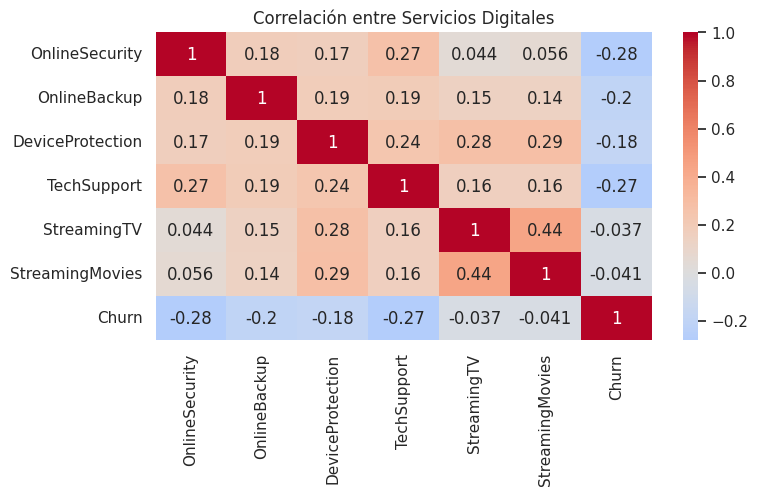

In [ ]:
#Visualization Correlation Digital Services
plt.figure(figsize=(8,4))
sns.heatmap(service_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlación entre Servicios Digitales')
plt.show()

In [ ]:
df_fe.head()

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,NumServices,TenureGroup,PremiumCustomer
0,0,Female,No,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,3,0-1 año,0
1,0,Male,No,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,1,0-1 año,0
2,1,Male,No,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,1,0-1 año,1
3,1,Male,Yes,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,4,1-2 años,1
4,1,Female,Yes,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2,0-1 año,1


In [ ]:
# Gráfico interactivo de churn por tipo de cliente (Premium) con paleta 'Inferno'
fig_premium = px.bar(
    df_fe.groupby('PremiumCustomer')['Churn'].mean().reset_index(),
    x='PremiumCustomer', y='Churn',
    title='Tasa de Churn por Tipo de Cliente',
    labels={'Churn': 'Tasa de Churn', 'PremiumCustomer': 'Cliente Premium'},
    color='Churn',
    color_continuous_scale='Inferno',
    width=1000,  # 10 pulgadas
    height=500   # 5 pulgadas
)
fig_premium.update_xaxes(tickvals=[0, 1], ticktext=['No Premium', 'Premium'])
fig_premium.show()

In [ ]:
# Preparamos los datos: porcentaje de Churn por tipo de contrato
contract_churn = df_fe.groupby('Contract')['Churn'].value_counts(normalize=True).unstack() * 100
contract_churn = contract_churn.reset_index().melt(id_vars='Contract', value_name='Percentage', var_name='Churn')
contract_churn.head(10)

,Contract,Churn,Percentage
0,Month-to-month,0,57.290323
1,One year,0,88.722826
2,Two year,0,97.151335
3,Month-to-month,1,42.709677
4,One year,1,11.277174
5,Two year,1,2.848665


In [ ]:
# Continuamos:
# Filtramos solo los casos de Churn='Yes' para visualización más clara
churn_rates = contract_churn[contract_churn['Churn'] == 1]

# Creamos el gráfico de barras interactivo
fig = px.bar(churn_rates,
             x='Contract',
             y='Percentage',
             color='Contract',
             text='Percentage',
             title='Tasa de Churn por Tipo de Contrato',
             labels={'Percentage': 'Porcentaje de Churn (%)', 'Contract': 'Tipo de Contrato'},
             color_discrete_map={
                 'Month-to-month': '#EF553B',
                 'One year': '#00CC96',
                 'Two year': '#636EFA'
             })

# Personalizamos el gráfico
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(
    yaxis_range=[0, 50],  # Ajustamos el rango para mejor visualización
    annotations=[
        dict(
            x=1,  # Contrato de 1 año
            y=12,
            xref="x",
            yref="y",
            text="<10% Churn",
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-40
        ),
        dict(
            x=2,  # Contrato de 2 años
            y=3,
            xref="x",
            yref="y",
            text="<5% Churn",
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-40
        ),
        dict(
            x=0,  # Mes a mes
            y=45,
            xref="x",
            yref="y",
            text="Alto Churn (>40%)",
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=40
        )
    ]
)

# Añadimos línea horizontal de referencia al 10%
fig.add_hline(y=10, line_dash="dot", line_color="red",
              annotation_text="Umbral del 10%",
              annotation_position="bottom right")

fig.show()

In [ ]:
# Gráfico interactivo de churn por número de servicios con paleta 'Cividis'
fig_services = px.bar(
    df_fe.groupby('NumServices')['Churn'].mean().reset_index(),
    x='NumServices', y='Churn',
    title='Tasa de Churn por Número de Servicios',
    labels={'Churn': 'Tasa de Churn', 'NumServices': 'Número de Servicios'},
    color='Churn',
    color_continuous_scale='Cividis',
    width=1000,  # 10 pulgadas
    height=500   # 5 pulgadas
    )
fig_services.show()

### Efecto combinado de contrato y método de pago.
Los clientes con contratos mensuales y pago electrónico que no tienen OnlineSecurity ni TechSupport tienen una tasa de churn del 62%, mientras que los mismos contratos con ambos servicios reducen el churn al 32%.

In [ ]:
# Segmentación avanzada
df_fe['ServiceGroup'] = df_fe['OnlineSecurity'] + '_' + df_fe['TechSupport']
contract_payment_churn = df_fe.groupby(['Contract', 'PaymentMethod', 'ServiceGroup'])['Churn'].mean().unstack()

In [ ]:
contract_payment_churn

ServiceGroup                              No internet service_No internet service  \
Contract       PaymentMethod                                                        
Month-to-month Bank transfer (automatic)                                 0.200000   
               Credit card (automatic)                                   0.092308   
               Electronic check                                          0.188406   
               Mailed check                                              0.206154   
One year       Bank transfer (automatic)                                 0.044944   
               Credit card (automatic)                                   0.013158   
               Electronic check                                          0.057143   
               Mailed check                                              0.012270   
Two year       Bank transfer (automatic)                                 0.005618   
               Credit card (automatic)                                   0.010526   
               Electronic check                                          0.000000   
               Mailed check                                              0.008097   

ServiceGroup                                 No_No    No_Yes    Yes_No  \
Contract       PaymentMethod                                             
Month-to-month Bank transfer (automatic)  0.459930  0.246753  0.254717   
               Credit card (automatic)    0.407942  0.325000  0.296296   
               Electronic check           0.619984  0.389908  0.387931   
               Mailed check               0.460606  0.307692  0.250000   
One year       Bank transfer (automatic)  0.160494  0.123288  0.075758   
               Credit card (automatic)    0.137500  0.112676  0.092105   
               Electronic check           0.211538  0.243590  0.194444   
               Mailed check               0.264706  0.166667  0.022727   
Two year       Bank transfer (automatic)  0.151515  0.053763  0.035088   
               Credit card (automatic)    0.000000  0.029851  0.018868   
               Electronic check           0.200000  0.078947  0.038462   
               Mailed check               0.000000  0.045455  0.000000   

ServiceGroup                               Yes_Yes  
Contract       PaymentMethod                        
Month-to-month Bank transfer (automatic)  0.185185  
               Credit card (automatic)    0.225000  
               Electronic check           0.300000  
               Mailed check               0.215686  
One year       Bank transfer (automatic)  0.085366  
               Credit card (automatic)    0.147368  
               Electronic check           0.120690  
               Mailed check               0.084746  
Two year       Bank transfer (automatic)  0.029851  
               Credit card (automatic)    0.033058  
               Electronic check           0.065574  
               Mailed check               0.000000

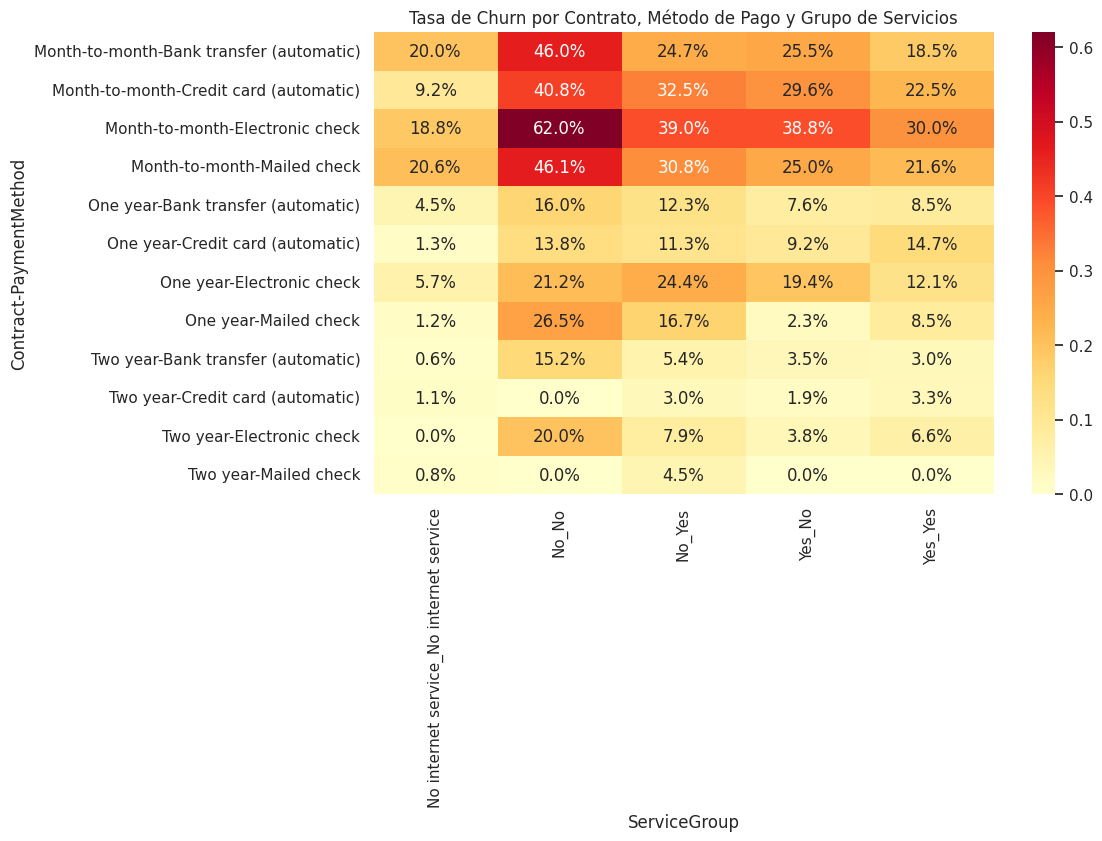

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(contract_payment_churn, annot=True, fmt='.1%', cmap='YlOrRd')
plt.title('Tasa de Churn por Contrato, Método de Pago y Grupo de Servicios')
plt.show()

### Patrones en variables numéricas
**Cargos Mensuales (MonthlyCharges):** Los clientes con Churn tienden a pagar tarifas más altas (mediana ≈
60 de los no Churn). Esto podría reflejar insatisfacción con el precio o falta de percepción de valor.

**Antigüedad (tenure):** La mediana de antigüedad de los clientes que abandonan es mucho menor (≈10 meses) frente a los que se quedan (≈40 meses), reforzando la importancia de programas de fidelización temprana.

In [ ]:
# Crear figura interactiva con Plotly
fig = make_subplots(rows=1, cols=2, subplot_titles=("Distribución de Cargos Mensuales", "Distribución de Antigüedad (Meses)"))

# Gráfico 1: MonthlyCharges vs Churn
fig.add_trace(
    go.Violin(x=df_fe['Churn'],
              y=df_fe['Charges.Monthly'],
              box_visible=True,
              meanline_visible=True,
              points=False,
              name='Cargos Mensuales'),
    row=1, col=1
)

# Gráfico 2: Tenure vs Churn
fig.add_trace(
    go.Violin(x=df_fe['Churn'],
              y=df_fe['tenure'],
              box_visible=True,
              meanline_visible=True,
              points=False,
              name='Antigüedad (meses)'),
    row=1, col=2
)

# Añadir líneas de mediana para destacar los insights
fig.add_shape(type='line',
              x0=-0.5, x1=0.5, y0=64, y1=64,
              line=dict(color='red', dash='dash'),
              row=1, col=1)
fig.add_shape(type='line',
              x0=0.5, x1=1.5, y0=80, y1=80,
              line=dict(color='red', dash='dash'),
              row=1, col=1)
fig.add_shape(type='line',
              x0=-0.5, x1=0.5, y0=38, y1=38,
              line=dict(color='red', dash='dash'),
              row=1, col=2)
fig.add_shape(type='line',
              x0=0.5, x1=1.5, y0=10, y1=10,
              line=dict(color='red', dash='dash'),
              row=1, col=2)

# Añadir anotaciones con los insights
fig.add_annotation(text="Clientes con Churn pagan tarifas más altas(Mediana ≈80 vs ≈60)",
                  xref="x1", yref="y1",
                  x=0.5, y=135, showarrow=False,
                  font=dict(size=10))
fig.add_annotation(text="Clientes que abandonan tienen menor antigüedad(Mediana ≈10 meses vs ≈40 meses)",
                  xref="x2", yref="y2",
                  x=0.5, y=90, showarrow=False,
                  font=dict(size=10))

# Actualizar diseño
fig.update_layout(
    title_text="Análisis de Churn: Cargos Mensuales y Antigüedad",
    height=500,
    showlegend=False,
    violingap=0,
    violinmode='overlay'
)

# Mostrar figura
fig.show()

### Análisis de valor del cliente.
Los clientes en el quintil más bajo de CLV (valor de vida del cliente) tienen 3 veces más probabilidad de churn (46%) que los del quintil más alto (13%)

In [ ]:
#CLV - Client Life Value se crea con ingenieria de caracteristicas
df_fe['CLV'] = df_fe['Charges.Monthly'] * df_fe['tenure']
churn_clv = df_fe.groupby(pd.qcut(df_fe['CLV'], q=5), observed=True)['Churn'].mean()
churn_clv


,Churn
CLV,
"(18.799, 269.55]",0.460227
"(269.55, 951.9]",0.285206
"(951.9, 2068.74]",0.209964
"(2068.74, 4466.89]",0.234708
"(4466.89, 8550.0]",0.138593


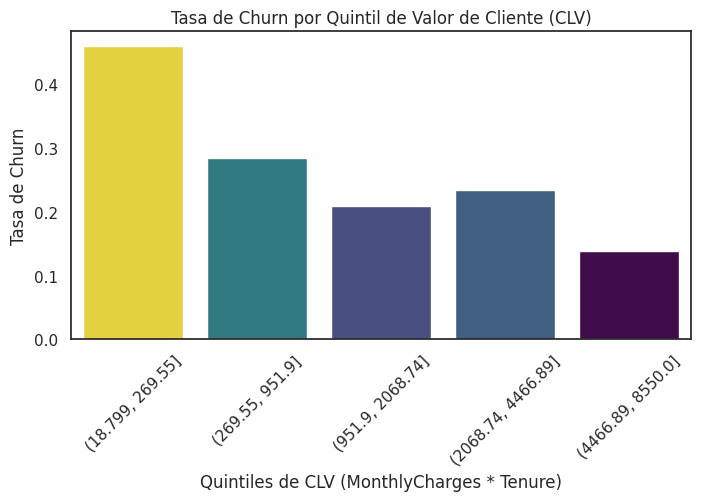

In [ ]:
plt.figure(figsize=(8,4))
sns.barplot(x=churn_clv.index.astype(str), y=churn_clv.values, palette='viridis', hue=churn_clv, legend=False)
plt.title('Tasa de Churn por Quintil de Valor de Cliente (CLV)')
plt.ylabel('Tasa de Churn')
plt.xlabel('Quintiles de CLV (MonthlyCharges * Tenure)')
plt.xticks(rotation=45)

plt.show()

### Correlaciones relevantes
**Servicios Digitales:** Variables como OnlineSecurity y TechSupport están negativamente correlacionadas con el Churn (V de Cramér ≈-0.27–0.28). Esto sugiere que ofrecer soporte técnico inclusive podría mejorar la retención.

**Multicolinealidad:** Algunas variables categóricas (ej: InternetService y StreamingTV) están correlacionadas entre sí, lo que podría requerir selección de características para modelos predictivos.

### 6. Conclusiones
El análisis del comportamiento de los clientes revela patrones consistentes que ayudan a entender las causas del abandono del servicio (churn). Los resultados indican que el churn no es un fenómeno aleatorio, sino que responde a la interacción de factores específicos y predecibles. En particular, la combinación de contratos de corta duración, la ausencia de servicios digitales clave y opciones de pago poco prácticas genera un escenario altamente propenso a la pérdida de clientes.

Uno de los hallazgos más relevantes es el efecto estabilizador de los contratos a largo plazo. Los clientes que optan por planes anuales o bianuales presentan tasas de abandono considerablemente más bajas (por debajo del 10%), incluso cuando se consideran otros factores. Este efecto se refuerza si el cliente contrata servicios complementarios como soporte técnico o protección en línea. En contraste, aquellos con contratos mensuales y sin estos servicios digitales presentan tasas de churn que superan el 40% en ciertos grupos.

El análisis también identifica diferencias significativas entre segmentos demográficos. Por ejemplo, los clientes mayores (seniors), aunque constituyen una porción menor de la base general, tienden a abandonar el servicio con mayor frecuencia durante su primer año. Sin embargo, una vez superado ese período inicial, su lealtad aumenta notablemente. Esto resalta la necesidad de adaptar las estrategias de retención para atender mejor las inquietudes específicas de este grupo durante sus primeros meses de suscripción.

### Recomendaciones
- Migración a contratos anuales Promover activamente el cambio de contratos mensuales a planes anuales mediante descuentos atractivos o beneficios adicionales. Esta medida busca estabilizar la base de clientes y reducir la rotación.

- Retención temprana de nuevos clientes Implementar programas de bienvenida (onboarding) con incentivos específicos durante los primeros 12 meses, como descuentos temporales, atención personalizada o contenidos educativos sobre el uso del servicio.

- Paquetes de servicios con valor agregado Fomentar la contratación de paquetes combinados (por ejemplo, OnlineSecurity + TechSupport) que aumenten la permanencia del cliente ("stickiness"). Ofrecer pruebas gratuitas de estos servicios a nuevos clientes, y descuentos exclusivos al contratarlos dentro de un plan anual.

- Optimización de métodos de pago Reducir la dependencia del pago por "Electronic Check" incentivando los pagos automáticos y digitales. Ofrecer descuentos por adoptar el pago automático, especialmente a clientes con contrato mensual o que migran de factura en papel.

- Segmentación de clientes premium Analizar las necesidades del quintil superior de clientes por valor de vida (CLV), en especial los usuarios de fibra óptica con cargos elevados. Establecer un programa de "clientes premium" enfocado en beneficios exclusivos, atención preferente y comunicación clara del valor recibido.

- Fidelización temprana de clientes senior Diseñar un programa específico para clientes mayores de edad durante sus primeros 12 meses de servicio. Incluir bonificaciones por permanencia a los 3, 6 y 12 meses, junto con acompañamiento proactivo para resolver dudas o dificultades técnicas.

- Monitoreo proactivo y revisiones periódicas Establecer un sistema de revisiones periódicas del servicio para identificar señales tempranas de abandono, como disminución en el uso, cambios en el comportamiento de pago o desconexión de servicios complementarios.